# I. Overview:

* Purpose:
    * this notebook provides detailed analysis on specific alerts

# II. Libraries:

In [1]:
from scipy import stats
import pandas as pd
from glob import glob
from pytz import timezone, UTC
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

EASTERN = timezone('US/Eastern')
UTC = timezone('UTC')

# III. Functions:

In [2]:
# 1. function to grab tickets:
def get_tickets(pwd, type_codes, cause_codes=None):
    '''
    PURPOSE:
        - grab and combine tickets into one df
    INPUT:
        - pwd (str, path of there the tickets are)
        - type_codes (list of str, denotes the location of the outages)
        - cause_codes (list of int, denotes that cause of the outages)
        - NOTED: for type codes and cause codes, please refer to the
    OUTPUT:
        - tickets (df; this has all the combined 
          tickets with the specify parameters)
    '''
    tickets = []
    
    for f in glob(pwd):
        df = pd.read_csv(f, index_col=False)
        df = df[pd.notnull(df['FDR_NUM'])]
        df.FDR_NUM = df.FDR_NUM.astype(int).astype(str)
        if cause_codes is not None:
            df = df.loc[df.IRPT_CAUS_CODE.isin(cause_codes)]
        df = df.loc[df.IRPT_TYPE_CODE.isin(type_codes)]
        df.POWEROFF = pd.to_datetime(df.POWEROFF)
        df.POWEROFF = df.POWEROFF.dt.tz_localize(EASTERN, ambiguous='NaT')
        df.POWEROFF = df.POWEROFF.dt.tz_convert(UTC)
        df.POWERRESTORE = pd.to_datetime(df.POWERRESTORE)
        df.POWERRESTORE = df.POWERRESTORE.dt.tz_localize(EASTERN, ambiguous='NaT')
        df.POWERRESTORE = df.POWERRESTORE.dt.tz_convert(UTC)
        tickets.append(df)
        
    tickets = pd.concat(tickets)
    tickets['YEAR'] = tickets.POWEROFF.dt.year
    tickets = tickets[['DW_TCKT_KEY', 'FDR_NUM', 'TRBL_TCKT_NUM', 'IRPT_TYPE_CODE', 
                       'SUPT_CODE', 'IRPT_CAUS_CODE', 'EQP_CODE',
                       'CMI', 'POWEROFF', 'POWERRESTORE',
                       'RPR_ACTN_TYPE', 'RPR_ACTN_SUB_TYPE', 'RPR_ACTN_DS', 'YEAR']]
    
    return tickets

In [3]:
# 2. functions that graphs distribution:
def _calc_fdr_tcms(fdr_num, tcms_df, tcms_type):
    '''
    PURPOSE:
        - calculates, print and graph fdr specific tcms info
    INPUT:
        - fdr_num (str), tcms_df (df of tcms)
        - tcms_type (str, lat or fdr etc.)
    OUTPUT:
        - N/A
    '''
    fdr_tcms = pd.DataFrame(
            tcms_df.loc[tcms_df['FDR_NUM']==fdr_num].sort(['POWEROFF'])['POWEROFF'])
    fdr_tcms_count = pd.DataFrame(
            {'Time': fdr_tcms['POWEROFF'].value_counts().index,
             'TCMS_count': fdr_tcms['POWEROFF'].value_counts().values}
        ).sort(['Time'])
    plt.figure(figsize=(20, 10))
    plt.plot(fdr_tcms_count['Time'], fdr_tcms_count['TCMS_count'], '--o--')
    plt.ylabel('# of tcms')
    plt.xlabel('time')
    plt.title('frequency of {} tcms over given time for feeder {}'.format(
        tcms_type, fdr_num))
    plt.show()
    print '{} tickets info for fdr {}'.format(
            tcms_type, fdr_num
        )
    print fdr_tcms_count
    
def _calc_distr(tcms_per_fdr_df, fdr_num, tcms_fdr_df, tcms_lat_df):
    '''
    PURPOSE:
        - graphs the distribution of tickets per feeder
        - for a specific fdr, calculates the percentile it belongs to
        - show the fdr on the distribution
    INPUT:
        - tcms_per_fdr_df (df; tickets per feeder)
        - fdr (str; desire fdr number)
        - fdr_tcms (df; master df of tcms)
    OUTPUT:
        -N/A
    '''
    # 1. calculate # of fdrs per a specific type of outage / all years freq:
    fdrs_per_out = tcms_per_fdr_df.groupby(['count']).agg('count').reset_index()
    fdrs_per_out.columns = ['tcms_count', 'fdr_count']
    # 2. add zeros:
    max_tcms, min_tcms =\
        fdrs_per_out['tcms_count'].max(), fdrs_per_out['tcms_count'].min()
    total_tcms_count = range(min_tcms, max_tcms+1)
    miss_tcms_count = list(set(total_tcms_count) - set(fdrs_per_out['tcms_count']))
    zero_tcms_df = pd.DataFrame({'tcms_count': list(miss_tcms_count), 'fdr_count': 0})
    fdrs_per_out = pd.concat([fdrs_per_out, zero_tcms_df])
    fdrs_per_out.sort(['tcms_count'], inplace=True)
    # 3. grab fdr specific tcms throughout time:
    fdr_tcms_count =\
        tcms_per_fdr_df.loc[
                tcms_per_fdr_df['FDR_NUM']==fdr_num
            ]['count'].values[0]
    # 4. calculates percentile:
    p_score =\
        str(stats.percentileofscore(tcms_per_fdr_df['count'].values, fdr_tcms_count))[0:7]
    # 5. print fdr tcms info:
    print 'In the past, fdr {} has {} fdr level tickets (percentile:{}%)'.format(
        fdr_num, fdr_tcms_count, p_score)
    print '______________________________________________________________________'
    # 6. graph fdr tcms info (for this fdr):
    _calc_fdr_tcms(fdr_num, tcms_fdr_df, 'feeder level')
    print '______________________________________________________________________'
    # 7. graph lat tcms info (for this fdr)
    _calc_fdr_tcms(fdr_num, tcms_lat_df, 'lat level')
    print '______________________________________________________________________'
    # 8. graph bar plot/hist:
    plt.figure(figsize=(20, 10))
    y_pos = np.arange(len(fdrs_per_out['tcms_count']))
    plt.bar(y_pos, fdrs_per_out['fdr_count'], align='center', alpha=0.5)
    plt.xticks(y_pos, fdrs_per_out['tcms_count'], rotation='vertical')
    plt.axvline(fdr_tcms_count-1, color='b')
    plt.text(
            fdr_tcms_count-0.8, 200,
            'feeder: {} (percentile:{}%)'.format(
                fdr_num, p_score), fontsize=20
        )
    plt.ylabel('# of fdrs')
    plt.xlabel('# of tcms')
    plt.title('frequency of feeders per # of tcms over given time')
    plt.show()

In [4]:
# 3: simple EDA for LG_PD_10:
def _LG_PD_10_EDA(alert_analysis_df):
    '''
    PURPOSE:
        - simple EDA with LG_PD_10 anomaly within an alert
    INPUT:
        - alert_analysis_df (df of a specific alert)
    OUTPUT:
        - N/A
    '''
    if alert_analysis_df.loc[alert_analysis_df['Anomaly']=='LG_PD_10'].empty:
        print 'There is no LG_PD_10 anomaly in this alert'
    else:
        loc_df =\
            alert_analysis_df.loc[alert_analysis_df['Anomaly']=='LG_PD_10']
        print 'There are {} LG_PD_10 for this alert'.format(loc_df.shape[0])
        for index, row in loc_df[['Signal','Time']].iterrows():
            print 'LG_PD_10 at time {} has LG_PD_PERC of {}'.format(
                row[1], row[0].split(' ')[6]) 

In [5]:
# 4. master function to do alert analysis:
def alert_EDA(alert_pwd, file_name):
    '''
    PURPOSE:
        - master function to do EDA on a specific alerts
    INPUT:
        - alert_pwd (str; path to the alert file)
        - file_name (str; name of the alert json)
    OUTPUT:
        - N/A
    '''
    # 1. load data:
    fdr_num = file_name[-11:-5]
    alert_json = pd.read_json(alert_pwd+file_name)
    print 'This alert is for feeder {}'.format(fdr_num)
    # 2. feeder past outage info:
    _calc_distr(tcms_per_fdr_perc, fdr_num, fdr_tickets, lat_tickets)
    # 3. organize alert df:
    alert_analysis = pd.DataFrame()
    alert_analysis['Anomaly'] = alert_json['anomalies'].apply(lambda x: x['Anomaly'])
    alert_analysis['DeviceType'] = alert_json['anomalies'].apply(lambda x: x['DeviceType'])
    alert_analysis['Signal'] = alert_json['anomalies'].apply(lambda x: x['Signal'])
    alert_analysis['Time'] = alert_json['anomalies'].apply(lambda x: x['Time'])
    # 4. Alert EDA:
    # a. anomaly counts:
    print '______________________________________________________________________'
    print 'Value count of anomaly:'
    print alert_analysis['Anomaly'].value_counts()
    # b. type of anomaly counts:
    print '______________________________________________________________________'
    print 'Value count of anomaly type:'
    print alert_analysis['DeviceType'].value_counts()
    # c. time counts:
    print '______________________________________________________________________'
    print 'Value count of anomaly time:'
    print alert_analysis['Time'].value_counts()
    # d. LG_PD_10 info:
    print '______________________________________________________________________'
    _LG_PD_10_EDA(alert_analysis)

# IV. EDA:

## i. Feeders health groups:

In [6]:
# 1. fetching feeder tcms:
tcms_pwd =\
    '/Users/erichsieh/Desktop/conda_envs/pam_modeling_e/modeling/data/tickets/TICKETS*'
fdr_tickets =\
    get_tickets(tcms_pwd, type_codes=['FDR', 'OCR'], cause_codes=[188, 189])
# 2. black out one hour prior to the outage for anomaly counting:
fdr_tickets['POWEROFF'] =\
    fdr_tickets['POWEROFF'].apply(lambda x: x-pd.DateOffset(hours=1))
# 3. finding the count per Feeder:
tcms_per_fdr =\
    fdr_tickets.groupby(['FDR_NUM', 'POWEROFF']).agg(['count'])['DW_TCKT_KEY'].reset_index()
# 4. calculates total tickets per fdr:
tcms_per_fdr_perc =\
    tcms_per_fdr.groupby(['FDR_NUM'])['count'].sum().reset_index()
tcms_per_fdr_perc.sort(columns='count', inplace=True)
# 5. max and min date of tcms:
print 'earliest tcms info: {}'.format(fdr_tickets['POWEROFF'].min())
print 'latest tcms info: {}'.format(fdr_tickets['POWEROFF'].max())
# 6. fetch lateral outages tcms:
lat_tickets = get_tickets(tcms_pwd, type_codes=['LAT'])

/Users/erichsieh/miniconda2/envs/pam_modeling_e/lib/python2.7/site-packages/ipykernel_launcher.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  # Remove the CWD from sys.path while we load stuff.


earliest tcms info: 2012-01-01 06:04:00
latest tcms info: 2017-03-03 19:27:00


## ii. Alerts EDA:

In [7]:
pwd =\
    '/Users/erichsieh/Desktop/conda_envs/alerts_EDA/alerts_json_data/'

### #1. Alert: 2017-06-06 23:12:00 EDT:

* Info:
    * level: Red Alert
    * Feeder: 809765
    * Model version 1

This alert is for feeder 809765
In the past, fdr 809765 has 17 fdr level tickets (percentile:93.5372%)
______________________________________________________________________


/Users/erichsieh/miniconda2/envs/pam_modeling_e/lib/python2.7/site-packages/ipykernel_launcher.py:52: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/erichsieh/miniconda2/envs/pam_modeling_e/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  del sys.path[0]
/Users/erichsieh/miniconda2/envs/pam_modeling_e/lib/python2.7/site-packages/ipykernel_launcher.py:17: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


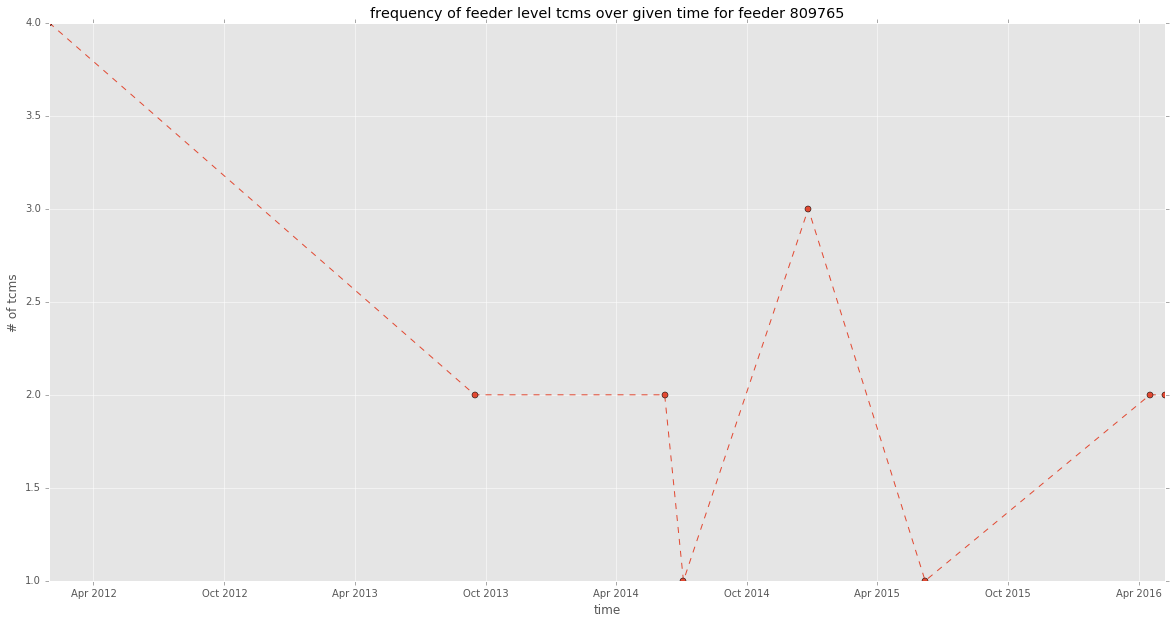

feeder level tickets info for fdr 809765
   TCMS_count                Time
0           4 2012-01-30 03:49:00
3           2 2013-09-15 15:14:00
4           2 2014-06-07 23:05:00
6           1 2014-07-04 04:53:00
1           3 2014-12-25 15:09:00
7           1 2015-06-06 21:05:00
5           2 2016-04-15 22:56:00
2           2 2016-05-07 05:19:00
______________________________________________________________________


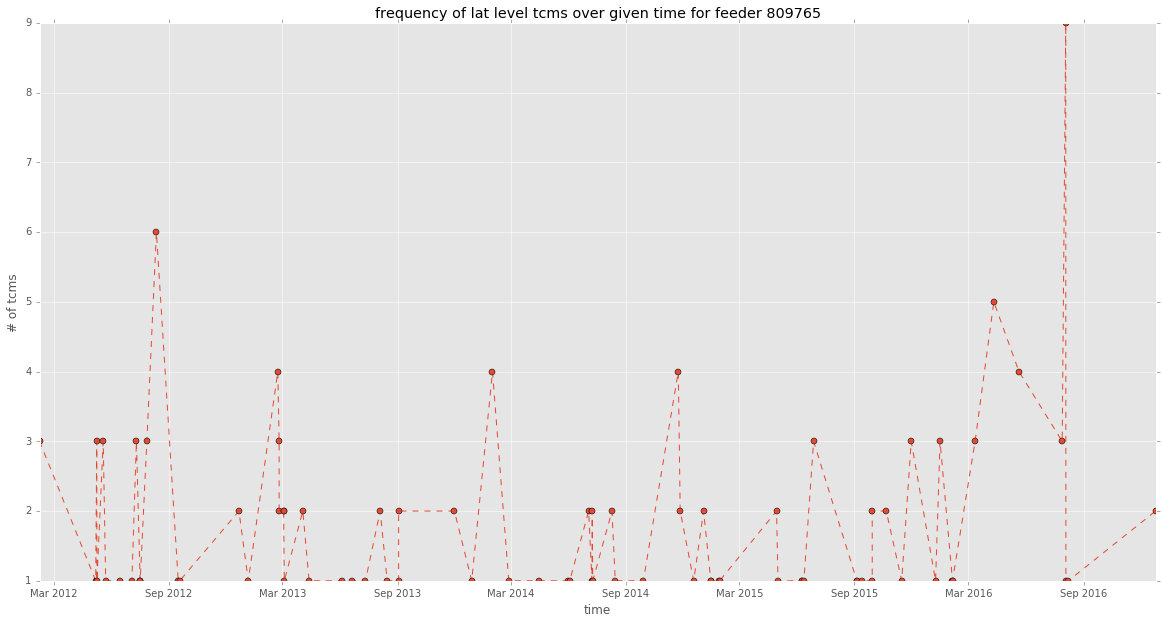

lat level tickets info for fdr 809765
    TCMS_count                Time
7            3 2012-02-07 03:19:00
58           1 2012-05-06 19:37:00
15           3 2012-05-08 12:00:00
63           1 2012-05-08 19:13:00
12           3 2012-05-18 19:12:00
54           1 2012-05-22 18:02:00
71           1 2012-06-15 02:00:00
60           1 2012-07-03 15:26:00
10           3 2012-07-10 20:21:00
38           1 2012-07-16 18:56:00
75           1 2012-07-16 19:01:00
55           1 2012-07-16 21:43:00
16           3 2012-07-27 12:30:00
1            6 2012-08-11 19:03:00
66           1 2012-09-15 16:17:00
53           1 2012-09-18 00:29:00
31           2 2012-12-21 15:34:00
45           1 2013-01-05 14:33:00
6            4 2013-02-21 17:22:00
13           3 2013-02-23 19:55:00
25           2 2013-02-23 20:02:00
26           2 2013-03-03 02:52:00
18           2 2013-03-03 02:53:00
67           1 2013-03-04 01:51:00
29           2 2013-04-02 16:25:00
50           1 2013-04-12 17:22:00
44           1 20

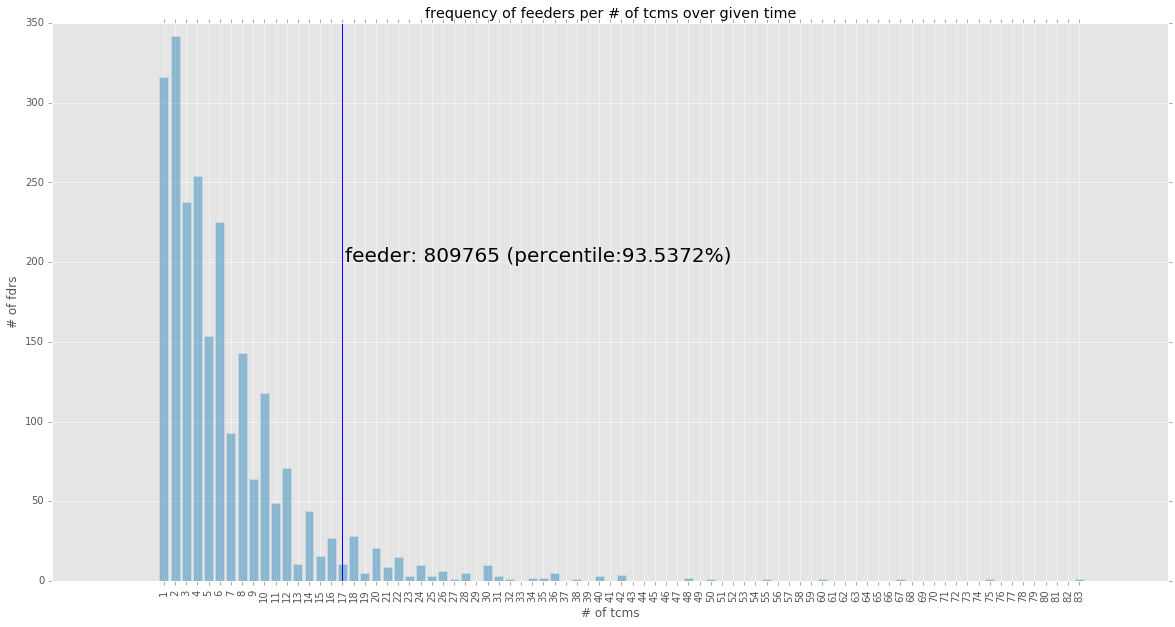

______________________________________________________________________
Value count of anomaly:
ZERO_VOLTAGE          3
FAULT_CURRENT         3
FAULT_ALARM           3
PF_SPIKES             2
BKR_CLOSE             2
BKR_OPEN              2
ZERO_CURRENT          1
FDRHD_DE_ENERGIZED    1
FDRHD_ENERGIZED       1
LG_PD_10              1
Name: Anomaly, dtype: int64
______________________________________________________________________
Value count of anomaly type:
PHASER    6
FAULT     6
FEEDER    4
FDRHD     2
AMI       1
Name: DeviceType, dtype: int64
______________________________________________________________________
Value count of anomaly time:
2017-06-07T03:12:00Z    19
Name: Time, dtype: int64
______________________________________________________________________
There are 1 LG_PD_10 for this alert
LG_PD_10 at time 2017-06-07T03:12:00Z has LG_PD_PERC of 89.0%


In [8]:
f_name = '2017-06-07T03_12_00Z_809765.json'
    
alert_EDA(pwd, f_name)

### 2. Alert: 2017-05-29 06:25:00 EDT:

* info:
    * level: Orange Alert
    * Feeder: 409363
    * Model version 1

This alert is for feeder 409363
In the past, fdr 409363 has 16 fdr level tickets (percentile:92.7186%)
______________________________________________________________________


/Users/erichsieh/miniconda2/envs/pam_modeling_e/lib/python2.7/site-packages/ipykernel_launcher.py:52: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/erichsieh/miniconda2/envs/pam_modeling_e/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  del sys.path[0]
/Users/erichsieh/miniconda2/envs/pam_modeling_e/lib/python2.7/site-packages/ipykernel_launcher.py:17: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


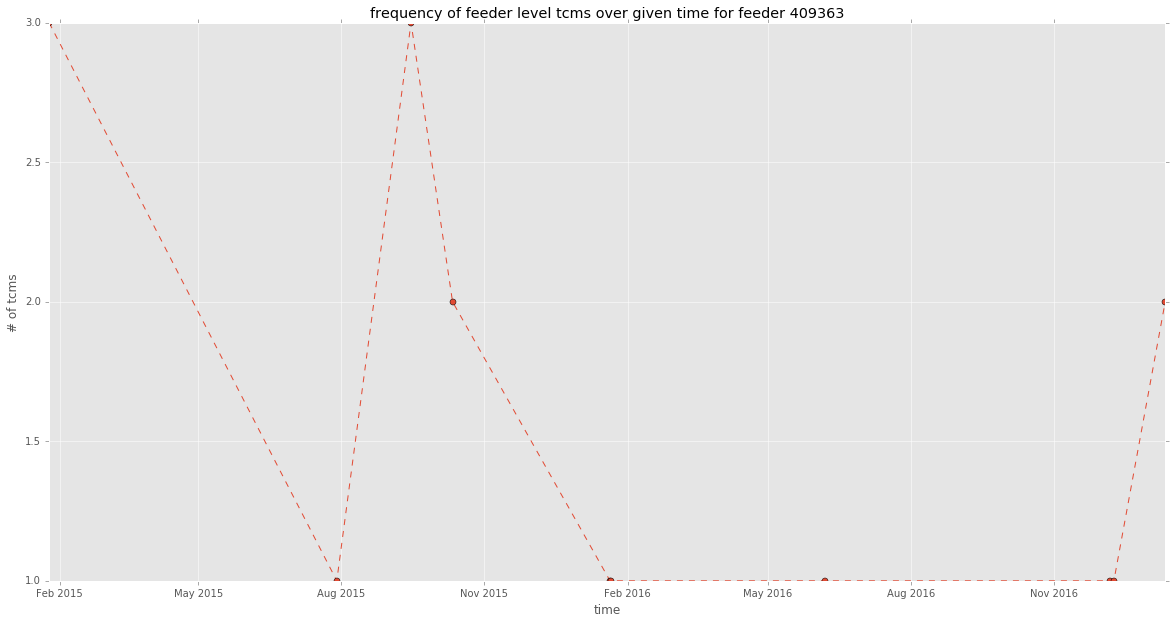

feeder level tickets info for fdr 409363
   TCMS_count                Time
1           3 2015-01-25 06:20:00
5           1 2015-07-29 02:14:00
0           3 2015-09-14 19:33:00
2           2 2015-10-11 12:03:00
7           1 2016-01-20 16:43:00
9           1 2016-01-21 00:13:00
4           1 2016-06-06 13:51:00
8           1 2016-12-07 03:54:00
6           1 2016-12-09 12:31:00
3           2 2017-01-11 12:00:00
______________________________________________________________________


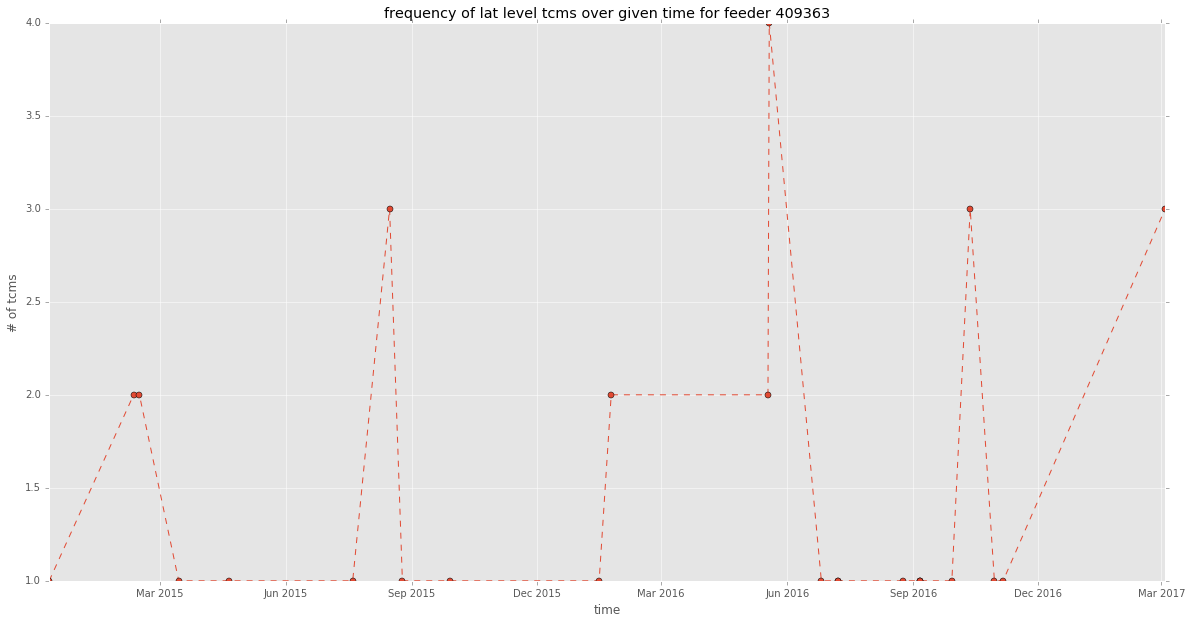

lat level tickets info for fdr 409363
    TCMS_count                Time
24           1 2014-12-10 09:33:00
4            2 2015-02-10 00:28:00
7            2 2015-02-14 04:59:00
19           1 2015-03-14 21:42:00
22           1 2015-04-20 17:00:00
15           1 2015-07-19 20:33:00
1            3 2015-08-15 18:53:00
23           1 2015-08-25 03:01:00
9            1 2015-09-28 14:29:00
21           1 2016-01-15 16:47:00
5            2 2016-01-24 12:10:00
6            2 2016-05-17 21:26:00
0            4 2016-05-18 19:45:00
8            1 2016-06-25 20:29:00
20           1 2016-07-08 03:10:00
17           1 2016-07-08 05:08:00
16           1 2016-08-24 18:40:00
13           1 2016-09-05 21:38:00
14           1 2016-09-06 00:22:00
12           1 2016-09-06 02:06:00
10           1 2016-09-29 01:45:00
3            3 2016-10-12 10:52:00
18           1 2016-10-30 02:57:00
11           1 2016-11-05 11:28:00
2            3 2017-03-03 18:05:00
____________________________________________________

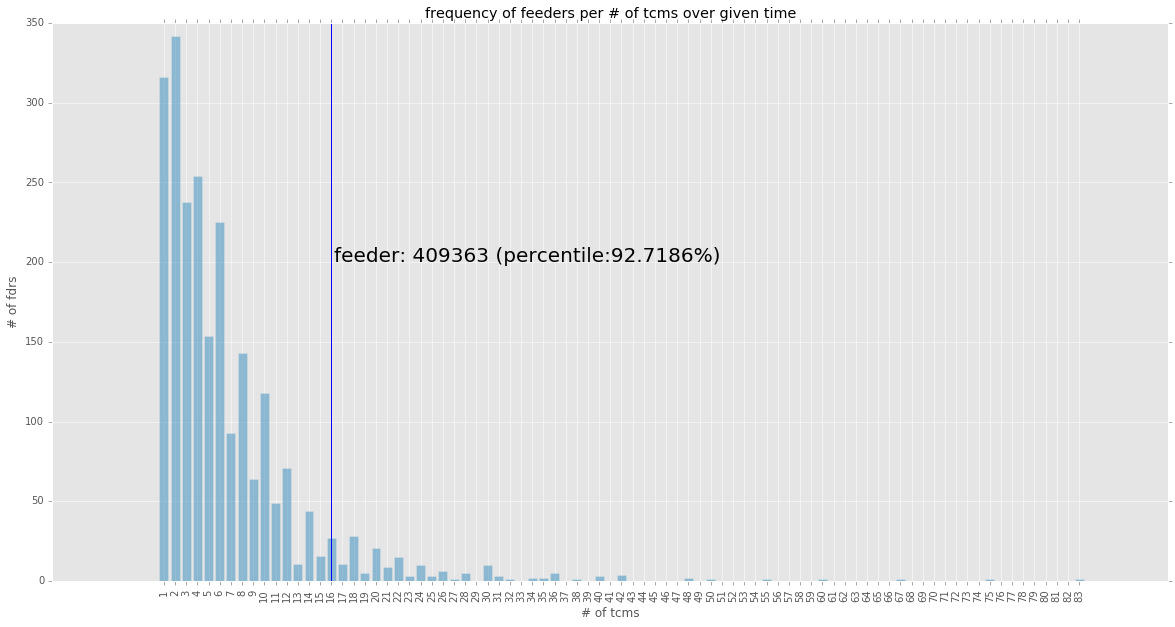

______________________________________________________________________
Value count of anomaly:
ZERO_VOLTAGE          3
ZERO_CURRENT          3
FAULT_CURRENT         3
ZERO_POWER            3
FAULT_ALARM           3
BKR_CLOSE             2
BKR_OPEN              2
PF_SPIKES             1
FDRHD_DE_ENERGIZED    1
FDRHD_ENERGIZED       1
Name: Anomaly, dtype: int64
______________________________________________________________________
Value count of anomaly type:
PHASER    10
FAULT      6
FEEDER     4
FDRHD      2
Name: DeviceType, dtype: int64
______________________________________________________________________
Value count of anomaly time:
2017-05-29T10:25:00Z    22
Name: Time, dtype: int64
______________________________________________________________________
There is no LG_PD_10 anomaly in this alert


In [9]:
f_name = '2017-05-29T10_25_00Z_409363.json'

alert_EDA(pwd, f_name)